In [1]:
project_dir = "~/ben_lustre/current_projects/kidney_glomTI_response"
setwd(project_dir)
suppressPackageStartupMessages(source("https://raw.githubusercontent.com/bjstewart1/helpful_singlecell/main/functions.R"))
ad <- import("anndata")
sc <- import("scanpy")
scv <- import("scvelo")
sp = import("scipy")
clean_theme <- theme_bw() + theme(axis.text = element_text(color = "black"), axis.title = element_text(color = "black"))

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


In [2]:
py_config()

python:         /home/jovyan/my-conda-envs/myenv/bin/python
libpython:      /home/jovyan/my-conda-envs/myenv/lib/libpython3.9.so
pythonhome:     /home/jovyan/my-conda-envs/myenv:/home/jovyan/my-conda-envs/myenv
version:        3.9.14 | packaged by conda-forge | (main, Nov 21 2022, 13:18:18)  [GCC 10.4.0]
numpy:          /home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/numpy
numpy_version:  1.22.4

NOTE: Python version was forced by RETICULATE_PYTHON

In [3]:
adata = sc$read_h5ad("data/raw/10X_3p/K294_pre_QC.h5ad")

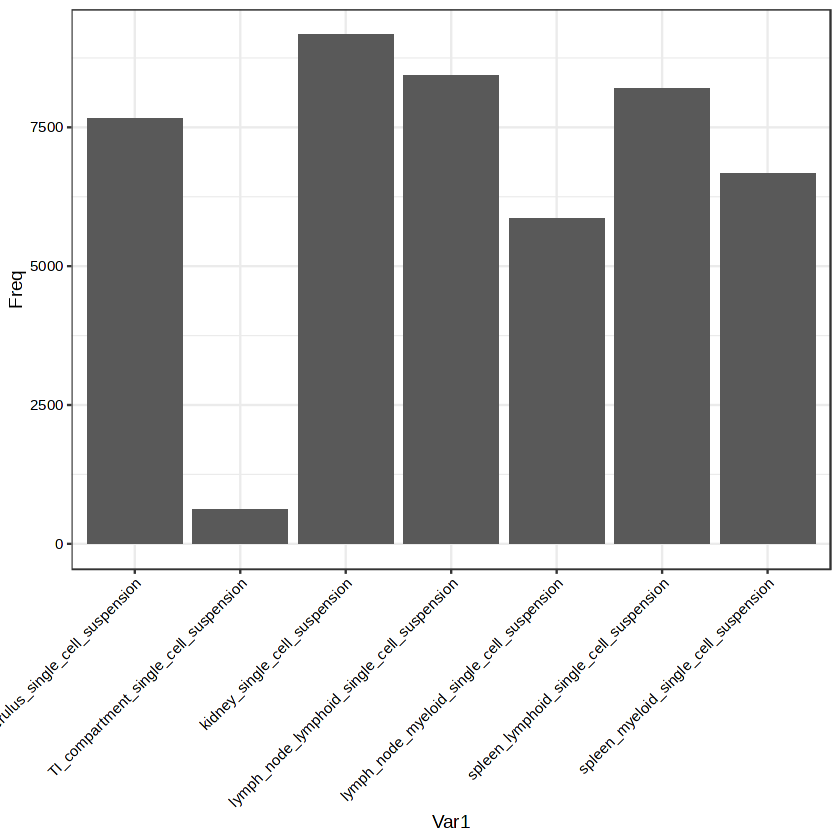

In [4]:
#barplot of cells by channel
ggplot(data.frame(table(adata$obs$tissue)), aes(x = Var1, y = Freq)) + geom_col() + clean_theme + theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [5]:
adata = adata$copy()

In [6]:
#now do some QC ####
adata$var$MT = 1:nrow(adata$var) %in% grep("^MT-", adata$var$Symbol)
sc$pp$calculate_qc_metrics(adata, qc_vars= list("MT"), inplace = TRUE, layer = 'raw_counts')

In [7]:
#QC cuts #####
n_genes_cut = log1p(500)
total_counts_cut= log1p(500)
pct_counts_in_top_50_genes_cut <- 70
pct_mito_cut_cells = 50

#plot study against number of genes
n_genes_histogram <- ggplot(adata$obs, aes(x = log1p_n_genes_by_counts)) + geom_histogram(bins = 100, fill = "grey30") + 
  geom_vline(xinteracept = n_genes_cut, color = "red") + clean_theme

#density plot of genes by MT counts
qcpl1<- density_plot_raster(x = adata$obs$log1p_n_genes_by_counts, y= adata$obs$log1p_total_counts_MT) + 
  clean_theme + xlab("log1p_n_genes_by_counts") + 
  ylab("log1p_total_counts_MT") + geom_vline(xintercept = n_genes_cut, color = "red") + ggtitle("cells log total genes by log total MT counts")

#density plot of genes by pct counts in top 50 genes
qcpl2 <- density_plot_raster(x = adata$obs$log1p_n_genes_by_counts, y= adata$obs$pct_counts_in_top_50_genes) + 
  clean_theme + xlab("log1p_n_genes_by_counts") + 
  ylab("pct_counts_in_top_50_genes") + 
  geom_vline(xintercept = n_genes_cut, color = "red") + geom_hline(yintercept = pct_counts_in_top_50_genes_cut, color = "red") + 
  ylim(c(0, 100)) + ggtitle("cells log total genes by % counts top 50")


#density plot of genes by total counts
qcpl3 <- density_plot_raster(x = adata$obs$log1p_n_genes_by_counts, y= adata$obs$log1p_total_counts) + 
  clean_theme + ylab("log1p_total_counts") + 
  xlab("log1p_n_genes_by_counts") + 
  geom_vline(xintercept = n_genes_cut, color = "red") + 
  geom_hline(yintercept = total_counts_cut, color = "red") + ggtitle("cells log total counts by log total genes")

Warning message in geom_vline(xinteracept = n_genes_cut, color = "red"):
“Ignoring unknown parameters: `xinteracept`”
Loading required package: ggrastr

Loading required package: MASS



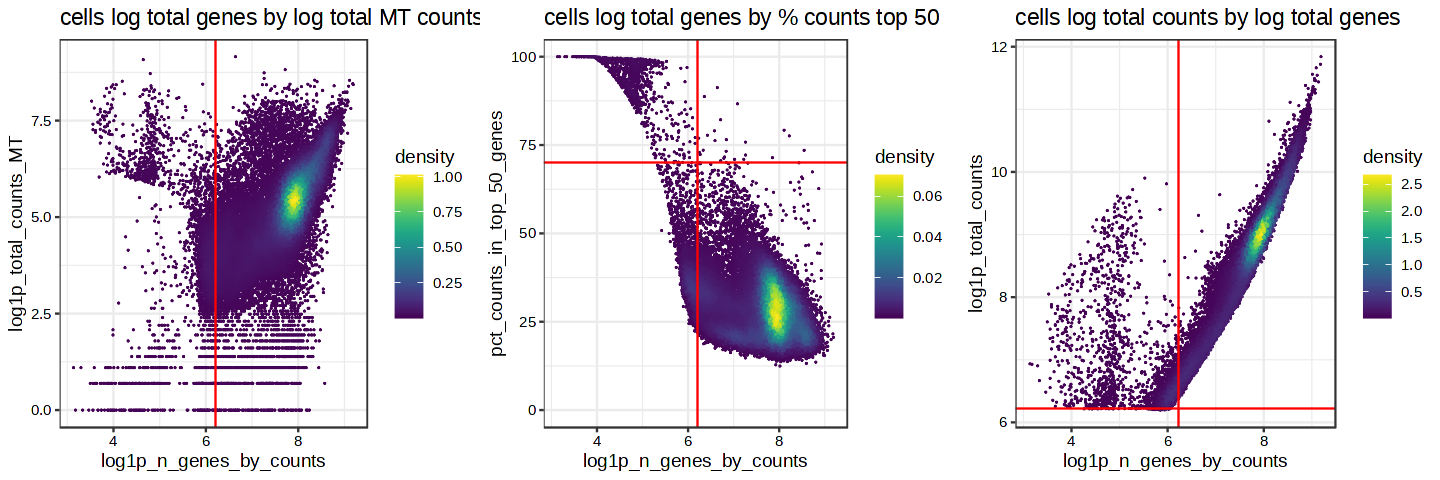

In [8]:
sc_qcpl = list(qcpl1, qcpl2, qcpl3)
#plot these out
options(repr.plot.width = 12, repr.plot.height = 4)
plot_grid(plotlist= sc_qcpl, nrow = 1, ncol = 3)

In [9]:
#now make some cuts ####
bad_barcodes <- list(adata$obs_names$values[adata$obs$log1p_n_genes_by_counts < n_genes_cut], 
                     adata$obs_names$values[adata$obs$log1p_total_counts < total_counts_cut], 
                     adata$obs_names$values[adata$obs$pct_counts_in_top_50_genes > pct_counts_in_top_50_genes_cut])
bad_barcodes <- Reduce(union, bad_barcodes)

adata$obs$qc_cuts <- !adata$obs_names$values %in% bad_barcodes

#look at cell status
table(adata$obs$qc_cuts)

table(adata$obs$status)

#make the cuts
adata <- adata[adata$obs$qc_cuts]

#we will do % mitochondrial cuts on a cluster specific level later.


FALSE  TRUE 
 3470 43120 


singlet 
  46590 

In [10]:
#remove unassigned cells ####
table(adata$obs$status) #small number of unassigned events
adata <- adata[!adata$obs$status %in% "unassigned"]


singlet 
  43120 

In [11]:
#add a core exclude set of genes ####
source('code/4_scRNAseq_preprocessing/nuissance_genes_grep.R')
adata$var$core_exclude <- core_exclude_grep(adata$var$Symbol)

In [12]:
#doublets
#run doublet processing
library(scDblFinder)
doublet_df = lapply(unique(adata$obs$channel), function(x){
message(x)
#subset the adata object
message("subsetting")
adata_sub = adata[adata$obs$channel %in% x]
#preprocess vanilla
message("preprocessing and clustering")
sc$pp$normalize_per_cell(adata_sub)
sc$pp$log1p(adata_sub)
#sc$pp$filter_genes(adata_sub, min_cells = ceiling(0.02*adata_sub$n_obs))
sc$pp$highly_variable_genes(adata_sub, flavor='seurat_v3', subset = FALSE, n_top_genes = as.integer(2000), layer = 'denoised_counts')
sc$pp$pca(adata_sub)
sc$pp$neighbors(adata_sub)
#cluster 
sc$tl$leiden(adata_sub, resolution = 1)
#make sce
#get count matrix
cmat = as(as.matrix(t(adata_sub$X)), "dgCMatrix") #unfortunately we have to do it this way..
#then make an SCE
sce = SingleCellExperiment::SingleCellExperiment(assays = list('counts' = cmat))
colnames(sce) = adata_sub$obs_names$values
#make some useful obs data
sce$known_doublets = adata_sub$obs$status %in% "doublet"
sce$clusters = adata_sub$obs$leiden
message("doublet analysis")
set.seed(100)
if(unique(adata_sub$obs$n_genotypes) > 1){
        message("more than one genotype in channel")
        set.seed(100)
sce <- scDblFinder(sce, 
                   knownDoublets = 'known_doublets',  #we use the known doublets we have
                   knownUse = 'discard',
                  clusters = 'clusters')
#get the fractions of each cluster that are from each genotype
samples = as.vector(table(factor(adata_sub$obs$genotype[adata_sub$obs$status %in% 'singlet'])))
reducedDim(sce, "PCA") = adata_sub$obsm$get("X_pca")
out <- recoverDoublets(sce, doublets=sce$known_doublets, k=15, samples= samples, use.dimred = 'PCA')
df = data.frame("dblf_cluster" = paste0(x, "_", colData(sce)$scDblFinder.cluster),
                "dblf_cuts" = colData(sce)$scDblFinder.class,
                "dblf_score" = colData(sce)$scDblFinder.score,
                "dblf_weighted" = colData(sce)$scDblFinder.weighted,
                "dblf_difficulty" = colData(sce)$scDblFinder.difficulty,
                "dblf_cxds_score" = colData(sce)$scDblFinder.cxds_score,
                "dblf_likely_origin" = colData(sce)$scDblFinder.mostLikelyOrigin,
                "dblf_ambiguous_origin" = colData(sce)$scDblFinder.originAmbiguous,
                "dblf_genotype_predicted" = ifelse(out$predicted, "doublet", "singlet"))}else{
    message("only one genotype in channel")
    #if not we don't have any known doublets
        set.seed(100)
    sce <- scDblFinder(sce, 
                  clusters = 'clusters')
df = data.frame("dblf_cluster" = paste0(x, "_", colData(sce)$scDblFinder.cluster),
                "dblf_cuts" = colData(sce)$scDblFinder.class,
                "dblf_score" = colData(sce)$scDblFinder.score,
                "dblf_weighted" = colData(sce)$scDblFinder.weighted,
                "dblf_difficulty" = colData(sce)$scDblFinder.difficulty,
                "dblf_cxds_score" = colData(sce)$scDblFinder.cxds_score,
                "dblf_likely_origin" = colData(sce)$scDblFinder.mostLikelyOrigin,
                "dblf_ambiguous_origin" = colData(sce)$scDblFinder.originAmbiguous,
                "dblf_genotype_predicted" = "singlet")
    }

return(df)
})

KID_CZI13249517

subsetting

preprocessing and clustering

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.8 GiB”
doublet analysis

only one genotype in channel

27 clusters

Creating ~7290 artificial doublets...

Dimensional reduction

Evaluating kNN...

Training model...

iter=0, 464 cells excluded from training.

iter=1, 314 cells excluded from training.

Threshold found:0.023

305 (4.1%) doublets called

KID_CZI13249518

subsetting

preprocessing and clustering

doublet analysis

only one genotype in channel

8 clusters

Creating ~5000 artificial doublets...

Dimensional reduction

Evaluating kNN...

Training model...

iter=0, 1 cells excluded from training.

iter=1, 0 cells excluded from training.

Threshold found:0.382

0 (0%) doublets called

KID_CZI13249519

subsetting

preprocessing and clustering

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.5 GiB”
doublet analysis

only one genotype in cha

In [13]:
adata$obs = cbind(adata$obs, do.call(rbind, doublet_df))

In [14]:
table(adata$obs$dblf_cuts )


singlet doublet 
  42400     720 

In [15]:
#keep the doublets in for now
#adata = adata[adata$obs$dblf_cuts %in% "singlet"]
#adata = adata[adata$obs$status %in% "singlet"]

In [16]:
#write out
adata$write_h5ad("data/raw/10X_3p/K294_raw.h5ad")

In [17]:
sessionInfo()

R version 4.0.4 (2021-02-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scDblFinder_1.7.2           MASS_7.3-60                
 [3] ggrastr_1.0.2               paletteer_1.5.0            
 [5] pbapply_1.7-2               SoupX_1.6.2                
 [7] igraph_1.2.6                DropletUtils_1.10.3        
